In [2]:
import os
import numpy as np
from six.moves import cPickle
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten

from prednet import PredNet
from data_utils import SequenceGenerator

from tqdm import tqdm

Using TensorFlow backend.


In [3]:
n_plot = 40
batch_size = 4
nt = 24

In [4]:
WEIGHTS_DIR = '../Training/weights/'
DATA_DIR = '../data/'
RESULTS_SAVE_DIR = './weather_results/'

In [5]:
y_labels = [
 'Visibility',
 'DB Temp C',
 'WB Temp C',
 'Dew Point',
 'Humidity',
 'WindSpeed',
 'Pressure',
]

In [6]:
weights_file = os.path.join(WEIGHTS_DIR, 'prednet_weather_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_weather_model.json')
test_file = os.path.join(DATA_DIR, 'x_test.hkl')
test_sources = os.path.join(DATA_DIR, 'sources_test.hkl')

In [7]:
# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

In [8]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))
predictions = test_prednet(inputs)
test_model = Model(inputs=inputs, outputs=predictions)

In [9]:
test_generator = SequenceGenerator(test_file, test_sources, nt, sequence_start_mode='unique', data_format=data_format)
X_test = test_generator.create_all()
X_hat = test_model.predict(X_test, batch_size)
if data_format == 'channels_first':
    X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
    X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

In [10]:
#Function used to create the average of the previous 5 frames in a series
def getAverage(test_frames):
    blank = np.zeros((20,40,7))
    window = [blank * 5]
    average = []
    for day in range(test_frames.shape[0]):
        day_average = []
        for hour in range(test_frames.shape[1]):
            day_average.append(np.mean(window[-5:], axis=0))
            window.append(test_frames[day,hour])
        average.append(np.array(day_average))
    return np.array(average)

In [11]:
#Naive Case 5 frame average
X_test_naive = getAverage(X_test)
mse_naive = np.nanmean((X_test[:, 1:] - X_test_naive[:,1:])**2)


In [12]:
#Used to explore a error in each channel of an image
per_channel_mse = []
for i in range(7):
    per_channel_mse.append(np.nanmean((X_test[:,1:,:,:,i] - X_hat[:, 1:,:,:,i])**2))

In [13]:
# Compare MSE of PredNet predictions vs. using last frame.  Write results to prediction_scores.txt
mse_model = np.nanmean( (X_test[:, 1:] - X_hat[:, 1:])**2 )  # look at all timesteps except the first
mse_prev = np.nanmean( (X_test[:, :-1] - X_test[:, 1:])**2 )
if not os.path.exists(RESULTS_SAVE_DIR): os.mkdir(RESULTS_SAVE_DIR)
f = open(RESULTS_SAVE_DIR + 'prediction_scores.txt', 'w')
f.write("Model MSE:\t{}\n".format(mse_model))
f.write("Prev Frame MSE:\t{}\n".format(mse_prev))
f.write("Naive MSE:\t{}".format(mse_naive))
f.close()

In [14]:
print("Model MSE:\t {}\nPrev Frame MSE:\t {}\nNaive MSE:\t {}".format(mse_model,mse_prev, mse_naive))

Model MSE:	 1.6844754924250083e-08
Prev Frame MSE:	 1.0880363277010474e-08
Naive MSE:	 4.413529927867206e-08


In [15]:
for i in range(7):
    print("{} MSE:\t {}".format(y_labels[i],per_channel_mse[i]) )

Visibility MSE:	 9.868519335043402e-09
DB Temp C MSE:	 1.3181296942832432e-08
WB Temp C MSE:	 3.7038310196635393e-09
Dew Point MSE:	 1.4059031272495304e-08
Humidity MSE:	 3.654186286894401e-08
WindSpeed MSE:	 3.6026573724257105e-08
Pressure MSE:	 4.070736636663241e-09


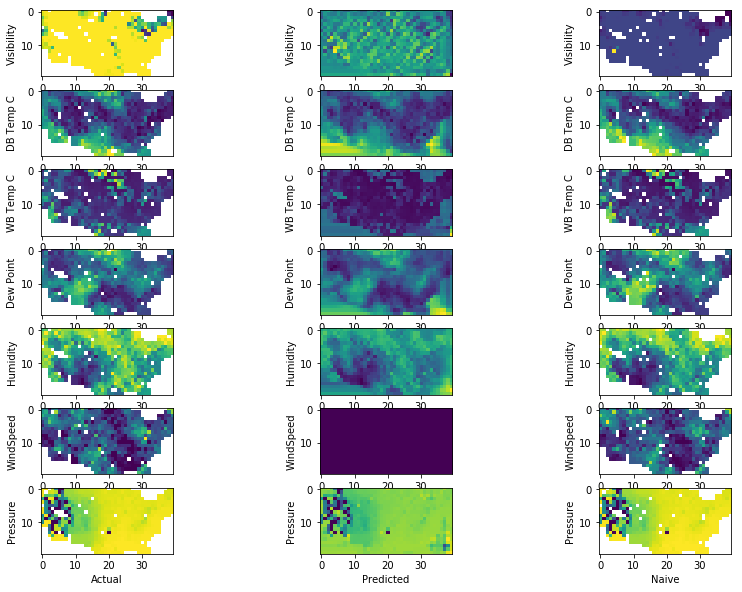

In [15]:
#Plot all 7 channels in a column for input image, model predicted image, and naive case image
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(7, 3)
grid.update(wspace=0., hspace=0.2)
for i in range(7):
    plt.subplot(grid[i*3])
    plt.imshow(X_test[0,23,:,:,i])
    plt.ylabel(y_labels[i])
    plt.xlabel('Actual', fontsize=10)
    
    plt.subplot(grid[i*3 +1])
    plt.imshow(X_hat[0,23,:,:,i])
    plt.ylabel(y_labels[i])
    plt.xlabel('Predicted', fontsize=10)
    
    plt.subplot(grid[i*3 + 2])
    plt.imshow(X_test_naive[0,23,:,:,i])
    plt.ylabel(y_labels[i])
    plt.xlabel('Naive', fontsize=10)

In [19]:
# Plot full length series of images
aspect_ratio = float(X_hat.shape[3]) / X_hat.shape[2]
plt.figure(figsize = (7*2*aspect_ratio,nt))
gs = gridspec.GridSpec(nt,2*7)
gs.update(wspace=0.1, hspace=0.)
plot_save_dir = os.path.join(RESULTS_SAVE_DIR, 'prediction_plots/')
if not os.path.exists(plot_save_dir): os.mkdir(plot_save_dir)
plot_idx = np.random.permutation(X_test.shape[0])[:n_plot]
for i in tqdm(plot_idx):
    for t in range(nt):
        for c in range(7):
            plt.subplot(gs[t*14 + c*2])
            plt.imshow(X_test[i,t,:,:,c], interpolation='none')
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
            if t==0: plt.xlabel('Actual', fontsize=10)

            plt.subplot(gs[t*14 + (c*2+1)])
            plt.imshow(X_hat[i,t,:,:,c], interpolation='none')
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
            if t==0: plt.xlabel('Predicted', fontsize=10)

    plt.savefig(plot_save_dir +  'plot_' + str(i) + '.png')
    plt.clf()


  0%|                                                                                           | 0/40 [00:00<?, ?it/s]
Exception in thread Thread-8:
Traceback (most recent call last):
  File "c:\users\dasputer\appdata\local\programs\python\python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "c:\users\dasputer\appdata\local\programs\python\python36\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "c:\users\dasputer\appdata\local\programs\python\python36\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [20:41<00:00, 31.04s/it]


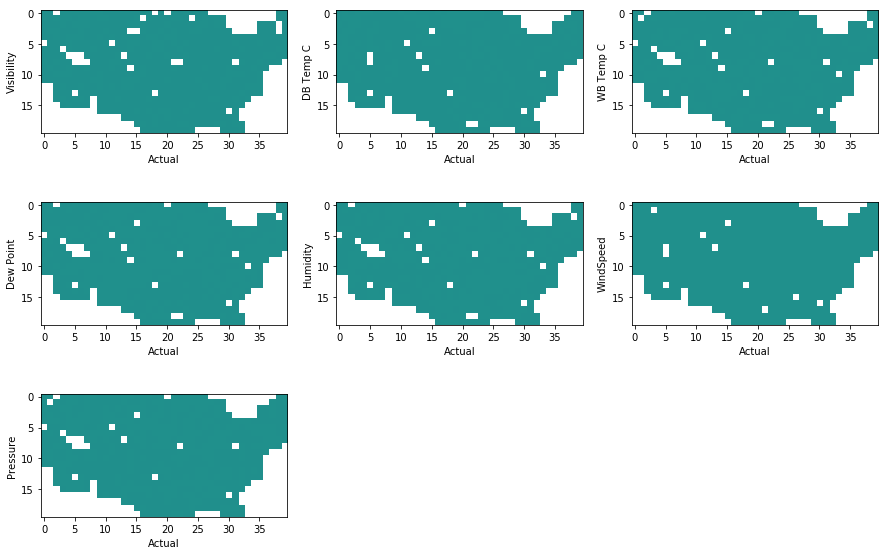

In [28]:
#plot difference between actual and predicted images
plt.figure(figsize=(15,10))
grid = gridspec.GridSpec(3, 3)
grid.update(wspace=0.2, hspace=0.2)
for i in range(7):
    plt.subplot(grid[i])
    plt.imshow(X_test[0,23,:,:,i] - X_hat[0,23,:,:,i],vmin=-1.,vmax=1.)
    plt.ylabel(y_labels[i])
    plt.xlabel('Actual', fontsize=10)